## Algoritmo esqueleto

In [12]:
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

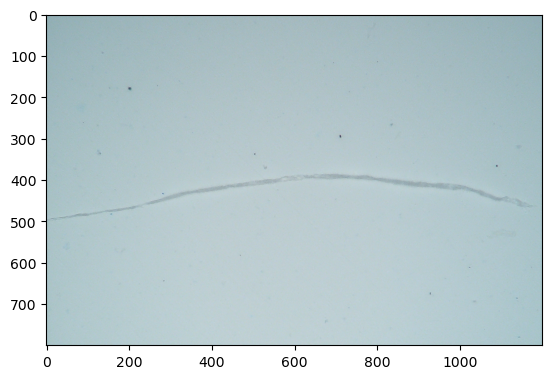

In [7]:
img = cv2.imread('../images/raw/Ai_F3C-1_1.tiff')
img = img[:800,::]
plt.imshow(img)

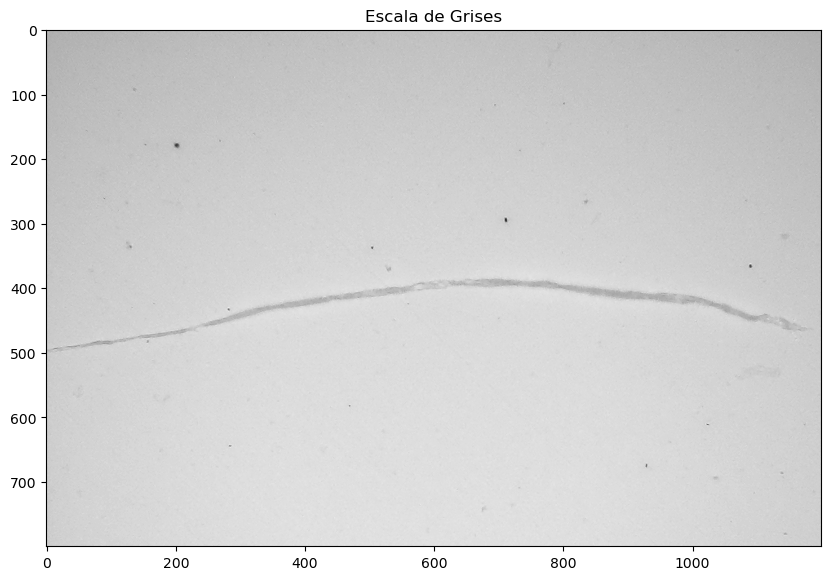

In [8]:
# Convertir a escala de grises
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(gray, cmap='gray')
plt.title('Escala de Grises')
plt.show()

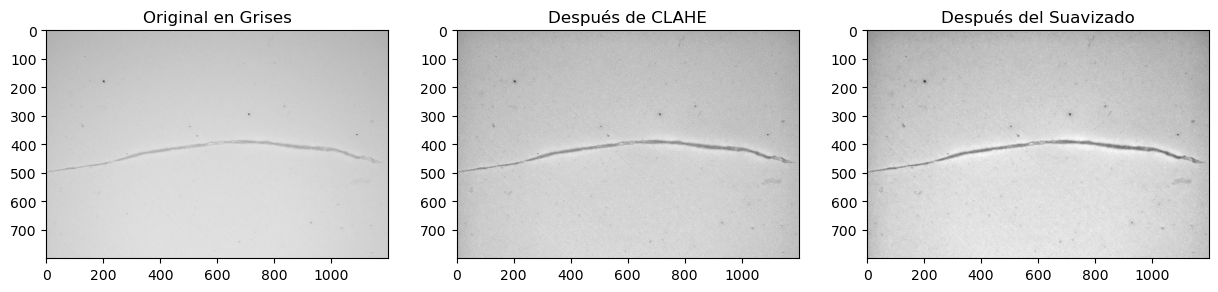

In [9]:
# 1. Mejora del contraste usando CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(gray)

# 2. Aplicar un filtro Gaussiano para reducir el ruido
blurred = cv2.GaussianBlur(clahe_img, (5,5), 0)

# Mostrar los resultados
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(gray, cmap='gray')
plt.title('Original en Grises')

plt.subplot(132)
plt.imshow(clahe_img, cmap='gray')
plt.title('Después de CLAHE')

plt.subplot(133)
plt.imshow(blurred, cmap='gray')
plt.title('Después del Suavizado')
plt.show()

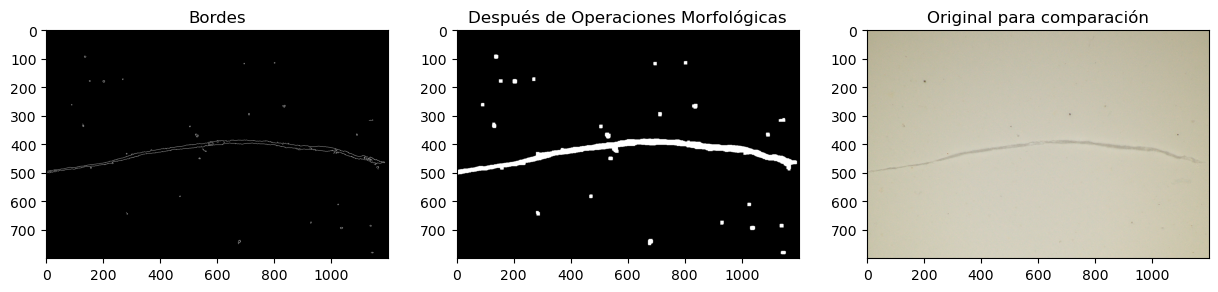

In [10]:
# 1. Ajustar los parámetros de Canny para mejorar la detección
edges = cv2.Canny(blurred, 20, 100)  # Reducir los umbrales para detectar bordes más sutiles

# 2. Aumentar las operaciones morfológicas
kernel = np.ones((5,5), np.uint8)  # Kernel más grande
dilated = cv2.dilate(edges, kernel, iterations=2)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=2)

# 3. Reducir el área mínima para la detección de contornos
min_area = 50  # Valor más pequeño para detectar secciones más sutiles

# 4. Mostrar la detección de bordes para verificar
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(edges, cmap='gray')
plt.title('Bordes')

plt.subplot(132)
plt.imshow(closed, cmap='gray')
plt.title('Después de Operaciones Morfológicas')

plt.subplot(133)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original para comparación')
plt.show()

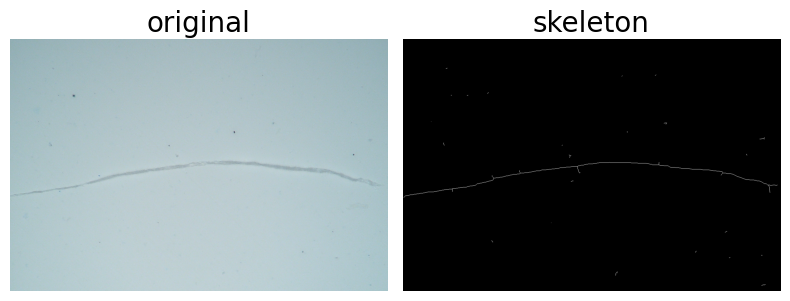

In [11]:
# perform skeletonization
skeleton = skeletonize(closed > 0)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

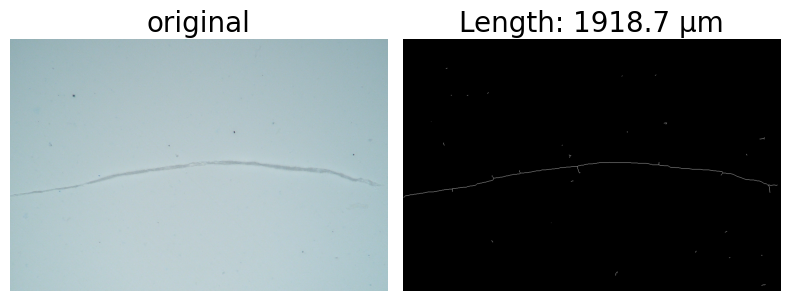

Longitud precisa del esqueleto: 1090.5 micras


In [13]:
# Asumiendo que ya tienes la imagen binaria 'closed'
# perform skeletonization
skeleton = skeletonize(closed > 0)

# Contar píxeles del esqueleto
skeleton_pixels = np.sum(skeleton)

# Calcular longitud en micras
pixels_to_microns = 400 / 300  # factor de conversión
length_microns = skeleton_pixels * pixels_to_microns

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title(f'Length: {length_microns:.1f} µm', fontsize=20)

fig.tight_layout()
plt.show()

# Para un cálculo más preciso de la longitud, podemos usar el método de encadenamiento
# Este método tiene en cuenta las conexiones diagonales
def calculate_skeleton_length(skeleton):
    # Etiquetar todos los puntos del esqueleto
    labeled_skeleton, num_features = ndimage.label(skeleton)
    
    # Obtener coordenadas de los puntos del esqueleto
    points = np.where(skeleton)
    y, x = points
    
    total_length = 0
    visited = set()
    
    # Para cada punto, calcular la distancia a sus vecinos
    for i in range(len(x)):
        if (y[i], x[i]) not in visited:
            visited.add((y[i], x[i]))
            # Revisar los 8 vecinos
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dy == 0 and dx == 0:
                        continue
                    ny, nx = y[i] + dy, x[i] + dx
                    if (ny, nx) not in visited and 0 <= ny < skeleton.shape[0] and 0 <= nx < skeleton.shape[1]:
                        if skeleton[ny, nx]:
                            # Distancia euclidiana para conexiones diagonales
                            distance = np.sqrt(dx*dx + dy*dy)
                            total_length += distance
                            visited.add((ny, nx))
    
    return total_length * pixels_to_microns

precise_length = calculate_skeleton_length(skeleton)
print(f"Longitud precisa del esqueleto: {precise_length:.1f} micras")